In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import sys
import tqdm
import multiprocessing as mp
from config import *

path = result_parent_directory + os.sep + 'step4c_btms_sizing_sensitivity_wait_time'
path_no_wait = result_parent_directory + os.sep + 'step4_btms_sizing_sensitivity'

result_directory = path + os.sep + 'analysis'
os.makedirs(result_directory, exist_ok=True)
figure_directory = path + os.sep + 'figures'
os.makedirs(figure_directory, exist_ok=True)

sizing_results_path = os.path.join(path, 'sizing_results')

print('Loading results from {}'.format(sizing_results_path))
print('Loading no wait results from {}'.format(path_no_wait))
print('result_directory: {}'.format(result_directory))
print('figure_directory: {}'.format(figure_directory))

Loading results from results\advancedScenario7\step4c_btms_sizing_sensitivity_wait_time\sizing_results
Loading no wait results from results\advancedScenario7\step4_btms_sizing_sensitivity
result_directory: results\advancedScenario7\step4c_btms_sizing_sensitivity_wait_time\analysis
figure_directory: results\advancedScenario7\step4c_btms_sizing_sensitivity_wait_time\figures


In [4]:
# sort files into folders with a_cost_sizing and d_wait_cost as folder names
# a_cost_sizing is top folder, d_wait_cost is subfolder

folder_sorted_sizing = 'sorted_sizing'
for folder1 in os.listdir(sizing_results_path):
    if not folder1.startswith(folder_sorted_sizing):
        path_folder = os.path.join(sizing_results_path, folder1)
        # load a_cost_sizing and d_wait_cost from first file in dir
        file = os.listdir(path_folder)[0]
        path_file = os.path.join(path_folder, file)
        df = pd.read_csv(path_file)
        a = df['param: btms size, a,b_sys,b_cap,b_loan,c,d_wait_cost'][1] * (365/12)
        d = df['param: btms size, a,b_sys,b_cap,b_loan,c,d_wait_cost'][6]
        # create folder structure
        # round a 
        path_folder_new = os.path.join(sizing_results_path, folder_sorted_sizing, 'a_' + str(round(a)))
        os.makedirs(path_folder_new, exist_ok=True)
        path_folder_new = os.path.join(path_folder_new, 'd_' + str(int(d)))
        os.makedirs(path_folder_new, exist_ok=True)
        # move files
        for file in os.listdir(path_folder):
            path_file = os.path.join(path_folder, file)
            shutil.move(path_file, path_folder_new)
        # remove empty folder
        os.rmdir(path_folder)

In [5]:
from functions.stats_sizing_function import stats_sizing_function_wait_time
# calculate stats for each charging station and save them in list and add multiindex: top-level: a_cost_sizing, second-level: d_wait_cost
stats_list = []

sizing_results_sorted = os.path.join(sizing_results_path, folder_sorted_sizing)
for folder1 in os.listdir(sizing_results_sorted):
    path_folder1 = os.path.join(sizing_results_sorted, folder1)
    # read a value from folder name
    a_value = float(folder1.split('_')[1])
    for folder2 in os.listdir(path_folder1):
        # read d value from folder name
        d_value = float(folder2.split('_')[1])
        path_folder2 = os.path.join(path_folder1, folder2)
        stats_i = []
        station_ids = []
        for file in os.listdir(path_folder2):
            station_id = int(file.split('.')[0].split('_')[2])
            station_ids.append(station_id)
            stats_i.append(stats_sizing_function_wait_time(pd.read_csv(os.path.join(path_folder2, file)), timestep))
        stats_i = pd.DataFrame(stats_i, index=station_ids)
        # make multiindex with a and d values
        stats_i.index = pd.MultiIndex.from_product([[a_value], [d_value], stats_i.index], names=['a', 'd', 'station_id'])
        # save stats in list
        stats_list.append(stats_i)
# concatenate all stats in one dataframe
stats_sizing = pd.concat(stats_list)
stats_sizing.sort_index(inplace=True)

In [6]:
index = stats_sizing.index
print('a_values: ', index.get_level_values(0).unique())
print('d_values: ', index.get_level_values(1).unique())
columns = stats_sizing.columns
print(columns)

a_values:  Float64Index([2.0, 5.0, 8.0, 10.0, 15.0], dtype='float64', name='a')
d_values:  Float64Index([1.0, 5.0, 10.0, 15.0, 20.0], dtype='float64', name='d')
Index(['btms_size', 'cost_a', 'cost_b_sys', 'cost_b_cap', 'cost_b_loan',
       'cost_b', 'cost_c', 'cost_total', 'share_cost_a', 'share_cost_b_sys',
       'share_cost_b_cap', 'share_cost_b_loan', 'share_cost_b', 'share_cost_c',
       'E_Charge', 'c_rate', 'cycles_day', 'btms_ratio', 'load_factor',
       'btms_peak_to_grid_ratio', 'grid_peak_to_charge_peak_ratio'],
      dtype='object')


this is how indexing works:
stats_sizing.loc[('a', 'd', 'station_id')]

In [47]:
stats_sizing.loc[(10.0), 'btms_size']

d     station_id
1.0   18            305.241823
      21            207.339620
      42            187.025407
      56            246.378631
      60            113.035121
                       ...    
20.0  1424          333.987431
      1430          257.948124
      1440          187.299128
      1442          222.452217
      1443          160.671719
Name: btms_size, Length: 785, dtype: float64

In [7]:
stats_sizing.xs(10.0, level='d')
stats_sizing.index.get_level_values('d').unique()

Float64Index([1.0, 5.0, 10.0, 15.0, 20.0], dtype='float64', name='d')

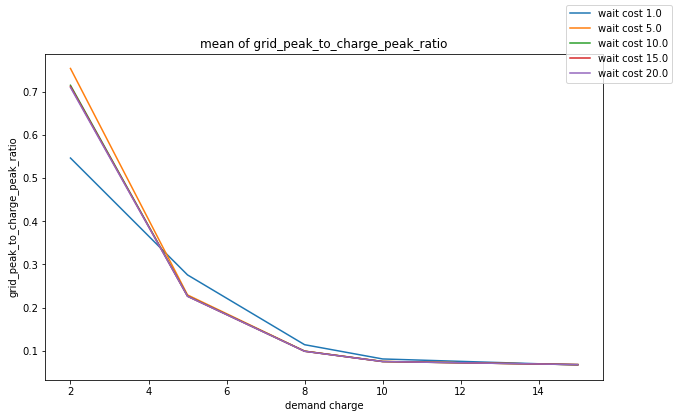

In [13]:
import matplotlib.pyplot as plt

stat_selected = 'grid_peak_to_charge_peak_ratio'

# plot results for all demand charges at every wait time cost

fig, ax = plt.subplots(figsize=(10, 6))
a = stats_sizing.index.get_level_values('a').unique()
for d in stats_sizing.index.get_level_values('d').unique():
    # plot mean for each demand charge
    y = stats_sizing.xs(d, level='d')[stat_selected].groupby('a').mean()
    ax.plot(a, y, label='wait cost ' + str(d))
    ax.set_title('mean of ' + stat_selected )
    ax.set_xlabel('demand charge')
    ax.set_ylabel(stat_selected)
fig.legend()